#Import Libraries

In [1]:
import pandas as pd

# Loding the datasets

In [2]:
converted_df = pd.read_excel('converted_leads_V1.xlsx')
not_converted_df = pd.read_excel('not_converted_L_V1.xlsx')

# View basic info

In [3]:
print("✅ Converted Leads:")
print(converted_df.shape)
print(converted_df.columns)

✅ Converted Leads:
(1020, 28)
Index(['Sl No', 'Form Name', 'Registered Name', 'Application No',
       'Registered Email', 'Lead Score', 'Registered Mobile', 'Form Status',
       'Payment Status', 'Payment Method', 'Work Experience', 'LinkedIn',
       'Job Title', 'Job Title 1', 'Program Interested In', 'Organization',
       'Organization_1', 'Industry', 'Industry Size (Bilion)', 'Bin', 'Type',
       'Categoty', 'Gender', 'Lead Stage', 'Publisher Name',
       'Application Owner', 'Application Completion Date', 'User Id'],
      dtype='object')


In [4]:
print("\n✅ Not Converted Leads:")
print(not_converted_df.shape)
print(not_converted_df.columns)


✅ Not Converted Leads:
(28320, 33)
Index(['Sl. No', 'Registered Name', 'User Registration Date',
       'Primary Traffic Channel', 'Primary Registration Campaign',
       'Publisher Name', 'Registered Email', 'Registered Mobile',
       'Program Interested in', 'Program Interested in2', 'Program', 'State',
       'City', 'Organization', 'Organization 1', 'Industry',
       'Industry Size (Billion)', 'Bin', 'Type', 'Categoty', 'Job Title',
       'Work Experience', 'Email Verification Status',
       'Email Verification Status 2', 'Lead Score', 'Lead Score 2',
       'Lead Score in Per', 'Lead Owner', 'Lead Owner2', 'Re-assigned On',
       'Payment Approved', 'Lead Remark', 'User Id'],
      dtype='object')


# Clean & Standardize the Columns

In [5]:
# STEP 1: Define useful columns for modeling
selected_columns = [
    'Registered Name', 'Registered Email', 'Registered Mobile', 'Job Title',
    'Work Experience', 'Organization', 'Industry', 'Industry Size (Billion)',
    'Type', 'Categoty', 'Publisher Name', 'Lead Score'
]

In [6]:
# STEP 2: Subset and rename the columns in both datasets
converted_df_clean = converted_df.rename(columns={
    'Industry Size (Bilion)': 'Industry Size (Billion)'
})[selected_columns].copy()
not_converted_df_clean = not_converted_df[selected_columns].copy()

In [7]:
# STEP 3: Add a label column
converted_df_clean['Converted'] = 1
not_converted_df_clean['Converted'] = 0

In [8]:
# STEP 4: Concatenate both into one DataFrame
df_combined = pd.concat([converted_df_clean, not_converted_df_clean], axis=0, ignore_index=True)

In [9]:
# STEP 5: Check for nulls and data types
print("✅ Combined Data Shape:", df_combined.shape)
print("\n📌 Nulls in Each Column:\n", df_combined.isnull().sum())
print("\n📌 Data Types:\n", df_combined.dtypes)

✅ Combined Data Shape: (29340, 13)

📌 Nulls in Each Column:
 Registered Name                9
Registered Email             862
Registered Mobile           1145
Job Title                   7275
Work Experience            15987
Organization                7912
Industry                   22821
Industry Size (Billion)    22890
Type                       22808
Categoty                   22824
Publisher Name                 0
Lead Score                   629
Converted                      0
dtype: int64

📌 Data Types:
 Registered Name             object
Registered Email            object
Registered Mobile           object
Job Title                   object
Work Experience             object
Organization                object
Industry                    object
Industry Size (Billion)    float64
Type                        object
Categoty                   float64
Publisher Name              object
Lead Score                 float64
Converted                    int64
dtype: object


# Data Cleaning (Work Experience, Industry Size, Categorical Fixes)
Clean Work Experience (text → numeric)

In [10]:
import numpy as np

In [11]:
# Clean work experience field based on reported bins

def convert_work_experience(exp):
    if pd.isna(exp) or exp == 'NA':
        return np.nan
    exp = str(exp).upper()
    if 'BELOW 4' in exp:
        return 2
    elif '4 TO 8' in exp:
        return 6
    elif '8 TO 12' in exp:
        return 10
    elif '12 TO 16' in exp:
        return 14
    elif '16 YEARS' in exp:
        return 18
    return np.nan

# Apply transformation
df_combined['Work_Experience_Years'] = df_combined['Work Experience'].apply(convert_work_experience)

# Summary
print("📌 Work Experience Summary:\n", df_combined['Work_Experience_Years'].describe())

📌 Work Experience Summary:
 count    13346.000000
mean         6.635097
std          5.185628
min          2.000000
25%          2.000000
50%          6.000000
75%         10.000000
max         18.000000
Name: Work_Experience_Years, dtype: float64


# Clean & Convert 'Industry Size (Billion)'

In [12]:
# Function to clean industry size and convert to float in billions
def clean_industry_size(val):
    if pd.isna(val):
        return np.nan
    val = str(val).replace(',', '').upper().strip()

    try:
        if 'BILLION' in val:
            return float(val.split()[0])
        elif 'B' in val:
            return float(val.replace('B', ''))
        elif 'MILLION' in val:
            return float(val.split()[0]) / 1000  # Convert million to billion
        elif 'M' in val:
            return float(val.replace('M', '')) / 1000
        elif 'CR' in val:
            return float(val.replace('₹', '').replace('CR', '')) * 0.12  # ₹1 Cr ≈ 0.12 B
        elif 'LAKH' in val:
            return float(val.replace('₹', '').replace('LAKH', '')) * 0.00012
        else:
            return float(val)
    except:
        return np.nan

# Apply function to clean industry size
df_combined['Industry_Size_Clean'] = df_combined['Industry Size (Billion)'].apply(clean_industry_size)

# Summary
print("📌 Cleaned Industry Size (in Billions):\n", df_combined['Industry_Size_Clean'].describe())

📌 Cleaned Industry Size (in Billions):
 count    6450.000000
mean       58.520803
std       103.070560
min         0.010000
25%        14.300000
50%        26.300000
75%        60.000000
max       611.000000
Name: Industry_Size_Clean, dtype: float64


# Clean Text Fields – Job Title, Industry, Organization, Type, Publisher
Clean and Normalize Text Columns

In [13]:
import re

In [14]:
# Function to clean text
def clean_text(val):
    if pd.isna(val):
        return 'unknown'
    val = str(val).lower().strip()
    val = re.sub(r'[^\w\s]', '', val)  # remove special characters
    return val

# Apply cleaning to key columns
df_combined['Job_Title_Clean'] = df_combined['Job Title'].apply(clean_text)
df_combined['Industry_Clean'] = df_combined['Industry'].apply(clean_text)
df_combined['Organization_Clean'] = df_combined['Organization'].apply(clean_text)
df_combined['Publisher_Clean'] = df_combined['Publisher Name'].apply(clean_text)
df_combined['Type_Clean'] = df_combined['Type'].apply(clean_text)

# Show sample cleaned values
print("📌 Sample Cleaned Job Titles:", df_combined['Job_Title_Clean'].unique()[:10])
print("📌 Sample Cleaned Industries:", df_combined['Industry_Clean'].unique()[:10])

📌 Sample Cleaned Job Titles: ['xx' 'unknown' 'freelancer' 'devops' 'team lead' 'manager' 'associate'
 'pse' 'analyst' 'intern']
📌 Sample Cleaned Industries: ['unknown' 'engineering  construction' 'it services cloud ai'
 'computers  it hardware' 'financial services' 'retail'
 'consulting  audit' 'it services' '297000'
 'it consulting  digital transformation']


#Categorical Encoding using LabelEncoder
Categorical variables were converted to numeric form using LabelEncoder. This included columns like Industry, Type, Organization, Publisher, and Job Title

In [15]:
from sklearn.preprocessing import LabelEncoder

# Define the columns to encode
categorical_cols = ['Job_Title_Clean', 'Industry_Clean', 'Organization_Clean', 'Publisher_Clean', 'Type_Clean']

# Dictionary to store encoders (optional, useful for inverse_transform if needed)
label_encoders = {}

# Apply Label Encoding
for col in categorical_cols:
    le = LabelEncoder()
    df_combined[col + '_Encoded'] = le.fit_transform(df_combined[col])
    label_encoders[col] = le

# Show sample of encoded data
df_combined[[col + '_Encoded' for col in categorical_cols]].head()

,Job_Title_Clean_Encoded,Industry_Clean_Encoded,Organization_Clean_Encoded,Publisher_Clean_Encoded,Type_Clean_Encoded
0,7799,89,10526,34,2
1,7600,89,9926,38,2
2,2548,89,717,10,2
3,1971,89,6976,28,2
4,7163,35,5695,28,0


#Feature Scaling (Standardization)

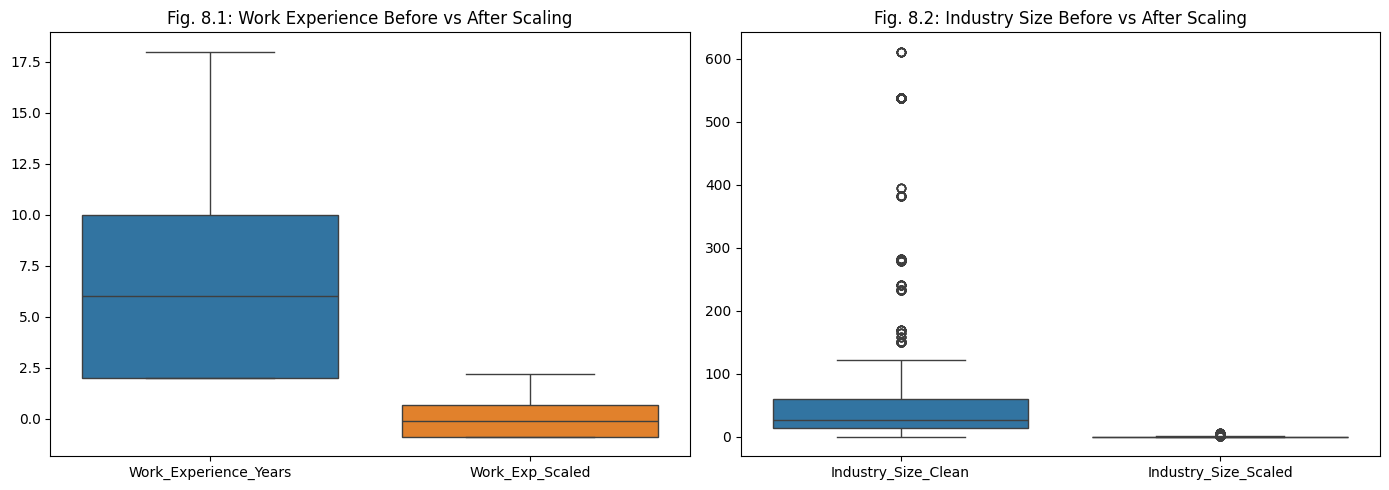

In [16]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# STEP 1: Standardize
scaler = StandardScaler()
df_combined['Work_Exp_Scaled'] = scaler.fit_transform(df_combined[['Work_Experience_Years']])
df_combined['Industry_Size_Scaled'] = scaler.fit_transform(df_combined[['Industry_Size_Clean']])

# STEP 2: Plot before vs after scaling
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Work Experience
sns.boxplot(data=df_combined[['Work_Experience_Years', 'Work_Exp_Scaled']], ax=axes[0])
axes[0].set_title("Fig. 8.1: Work Experience Before vs After Scaling")

# Industry Size
sns.boxplot(data=df_combined[['Industry_Size_Clean', 'Industry_Size_Scaled']], ax=axes[1])
axes[1].set_title("Fig. 8.2: Industry Size Before vs After Scaling")

plt.tight_layout()
plt.show()

# Constructing the Final Dataset (Analytical Base Table - ABT)

In [17]:
# STEP 1: Final feature selection
final_features = [
    'Work_Exp_Scaled', 'Industry_Size_Scaled', 'Job_Title_Clean_Encoded',
    'Industry_Clean_Encoded', 'Organization_Clean_Encoded', 'Publisher_Clean_Encoded',
    'Type_Clean_Encoded','Converted'
]

df_model = df_combined[final_features].dropna()  # Drop rows with any nulls in final feature set

# STEP 2: Feature Matrix and Target Vector
X = df_model.drop(columns=['Converted'])
y = df_model['Converted']

# STEP 3: Print dataset summary
print(f"✅ Final ABT shape: {df_model.shape}")
print(f"🔹 Feature matrix (X): {X.shape}")
print(f"🔹 Target vector (y): {y.shape}")
print(f"🔹 Converted Lead Ratio:\n{y.value_counts(normalize=True).round(2)}")

✅ Final ABT shape: (4082, 8)
🔹 Feature matrix (X): (4082, 7)
🔹 Target vector (y): (4082,)
🔹 Converted Lead Ratio:
Converted
0    0.89
1    0.11
Name: proportion, dtype: float64


Train size: (3265, 7)
Test size: (817, 7)
Class distribution in test set:
Converted
0    727
1     90
Name: count, dtype: int64


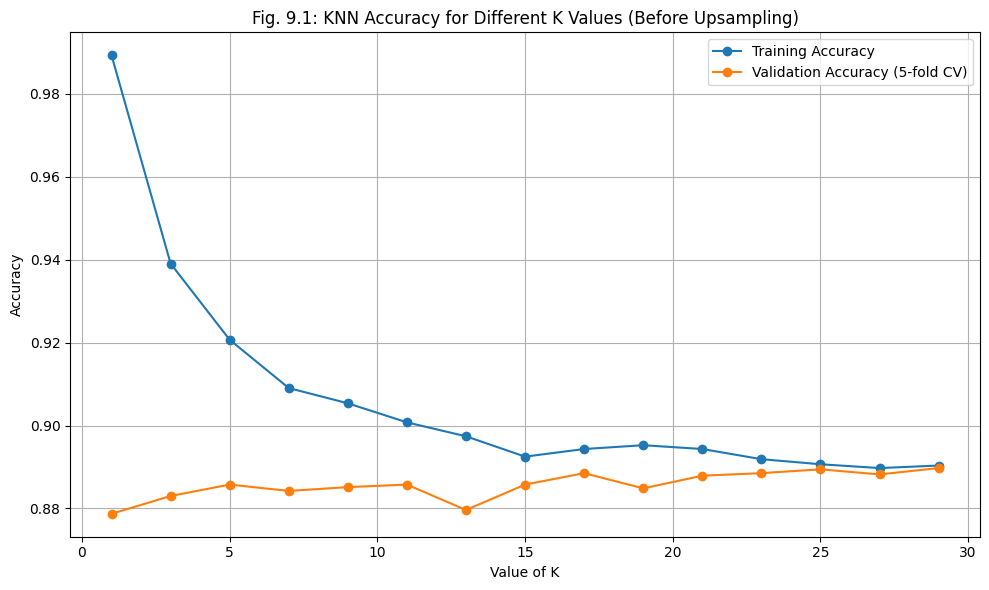


✅ Optimal K (Before Upsampling): 29

 Classification Report (Before Upsampling):
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       727
           1       1.00      0.01      0.02        90

    accuracy                           0.89       817
   macro avg       0.95      0.51      0.48       817
weighted avg       0.90      0.89      0.84       817



<Figure size 600x400 with 0 Axes>

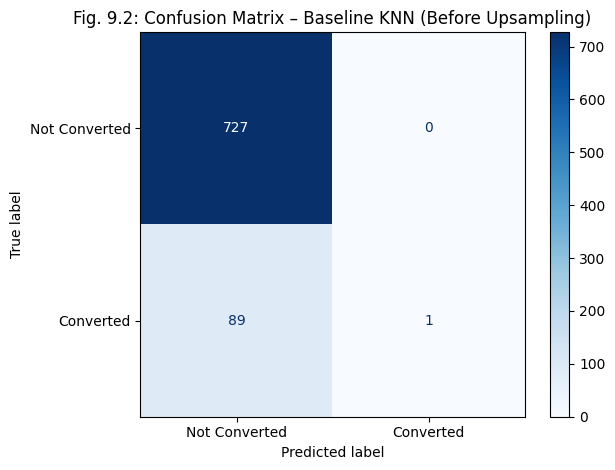

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Use df_model for the baseline model
X = df_model.drop(columns=['Converted'])
y = df_model['Converted']

# Train-test split (stratify to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)
print("Class distribution in test set:")
print(y_test.value_counts())

# Find Optimal K (Cross-validation)
k_range = range(1, 31, 2)
train_scores = []
cv_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train, y_train))
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Plot Fig 9.1 (K vs Accuracy)
plt.figure(figsize=(10, 6))
plt.plot(k_range, train_scores, label='Training Accuracy', marker='o')
plt.plot(k_range, cv_scores, label='Validation Accuracy (5-fold CV)', marker='o')
plt.xlabel('Value of K')
plt.ylabel('Accuracy')
plt.title('Fig. 9.1: KNN Accuracy for Different K Values (Before Upsampling)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Train Final KNN with Best K (Before Upsampling)
optimal_k = k_range[np.argmax(cv_scores)]
print(f"\n✅ Optimal K (Before Upsampling): {optimal_k}")

final_knn = KNeighborsClassifier(n_neighbors=optimal_k)
final_knn.fit(X_train, y_train)
y_pred = final_knn.predict(X_test)

# Classification Report (Before Upsampling)
print("\n Classification Report (Before Upsampling):")
print(classification_report(y_test, y_pred))

# Confusion Matrix (Before Upsampling)
cm_baseline = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=['Not Converted', 'Converted'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Fig. 9.2: Confusion Matrix – Baseline KNN (Before Upsampling)")
plt.tight_layout()
plt.show()

#Descriptive Statistics and Visual Insights

Histogram of Work Experience – Converted Leads Only


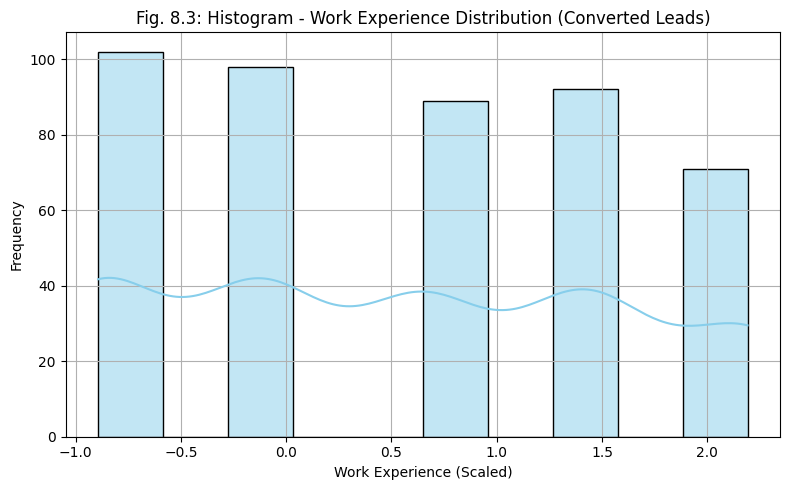

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter only converted leads
converted_only = df_model[df_model['Converted'] == 1]

plt.figure(figsize=(8, 5))
sns.histplot(converted_only['Work_Exp_Scaled'], bins=10, kde=True, color='skyblue')
plt.title('Fig. 8.3: Histogram - Work Experience Distribution (Converted Leads)')
plt.xlabel('Work Experience (Scaled)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


Top Industries Among Converted Leads

/tmp/ipython-input-3874805896.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_industries.values, y=top_industries.index, palette='viridis')


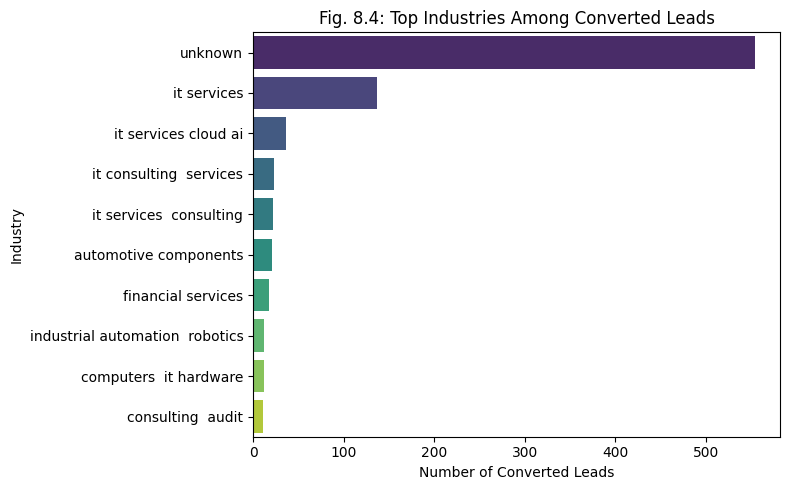

In [20]:
top_industries = df_combined[df_combined['Converted'] == 1]['Industry_Clean'].value_counts().head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_industries.values, y=top_industries.index, palette='viridis')
plt.title('Fig. 8.4: Top Industries Among Converted Leads')
plt.xlabel('Number of Converted Leads')
plt.ylabel('Industry')
plt.tight_layout()
plt.show()


/tmp/ipython-input-3176169392.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=industry_counts.values, y=industry_counts.index, palette='viridis')


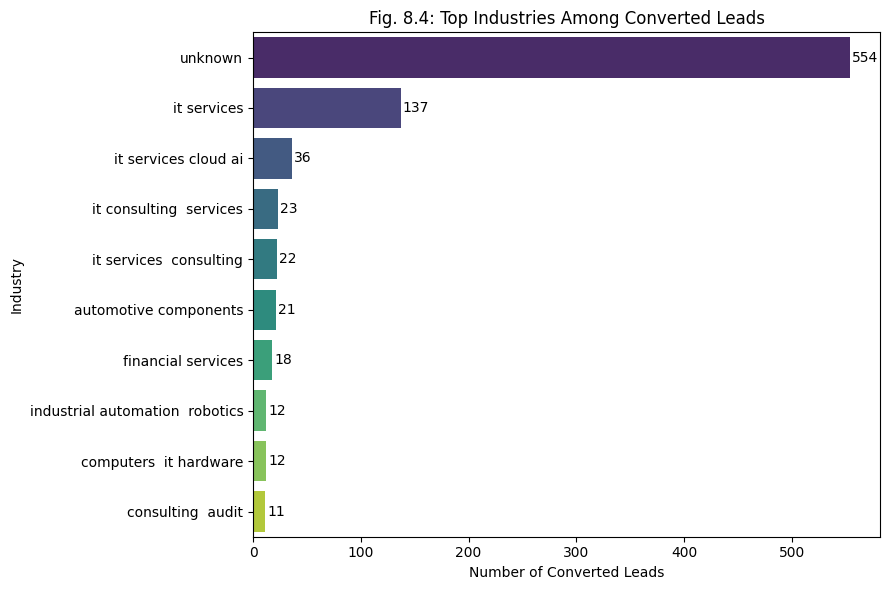

In [21]:
industry_counts = df_combined[df_combined['Converted'] == 1]['Industry_Clean'].value_counts().head(10)
plt.figure(figsize=(9, 6))
sns.barplot(x=industry_counts.values, y=industry_counts.index, palette='viridis')

for index, value in enumerate(industry_counts.values):
    plt.text(value + 2, index, str(value), va='center')

plt.title('Fig. 8.4: Top Industries Among Converted Leads')
plt.xlabel('Number of Converted Leads')
plt.ylabel('Industry')
plt.tight_layout()
plt.show()


/tmp/ipython-input-2200991716.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=work_exp_counts.values, y=work_exp_counts.index, palette='crest')


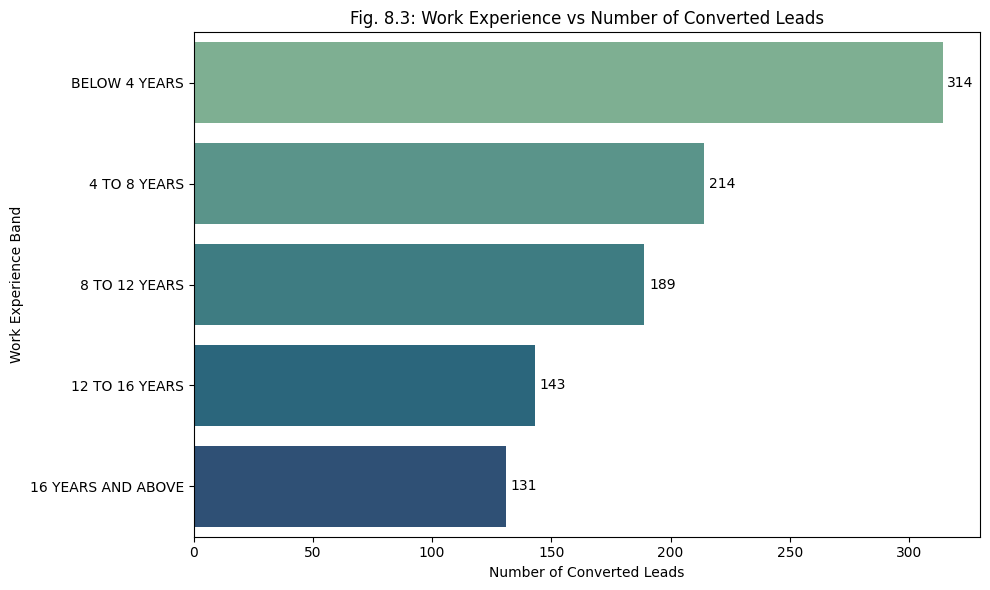

In [22]:
work_exp_counts = df_combined[df_combined['Converted'] == 1]['Work Experience'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=work_exp_counts.values, y=work_exp_counts.index, palette='crest')

for index, value in enumerate(work_exp_counts.values):
    plt.text(value + 2, index, str(value), va='center')

plt.title('Fig. 8.3: Work Experience vs Number of Converted Leads')
plt.xlabel('Number of Converted Leads')
plt.ylabel('Work Experience Band')
plt.tight_layout()
plt.show()


/tmp/ipython-input-3134440187.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


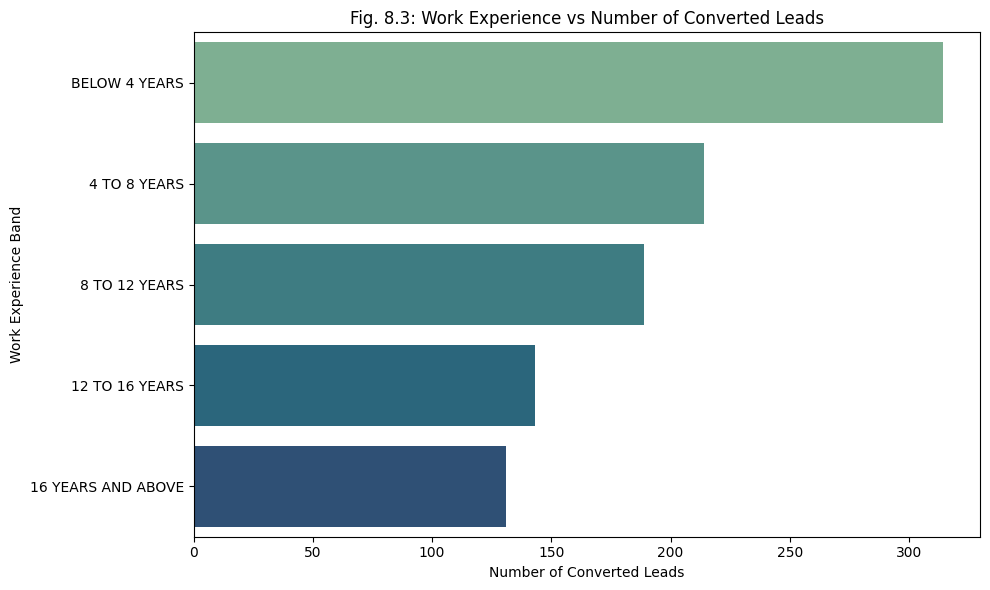

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter only converted leads
converted_data = df_combined[df_combined['Converted'] == 1]

# Plot: Work Experience vs Number of Converted Leads
plt.figure(figsize=(10,6))
sns.countplot(
    y='Work Experience',
    data=converted_data,
    order=converted_data['Work Experience'].value_counts().index,
    palette='crest'
)
plt.title("Fig. 8.3: Work Experience vs Number of Converted Leads")
plt.xlabel("Number of Converted Leads")
plt.ylabel("Work Experience Band")
plt.tight_layout()
plt.show()


In [24]:
# Crosstab of Work Experience vs Conversion Label
pd.crosstab(df_combined['Work Experience'], df_combined['Converted'])


Converted,0,1
Work Experience,,
3,2,0
5,2,0
10,1,0
12 TO 16 YEARS,1155,143
16 YEARS AND ABOVE,959,131
4 TO 8 YEARS,2981,214
8 TO 12 YEARS,1819,189
BELOW 4 YEARS,5441,314
BELOW_4_YEARS,1,0


#Top Publisher Channels (Converted Leads Only)

In [25]:
# Create cleaned publisher name column
df_combined['Publisher_Name_Clean'] = df_combined['Publisher Name'].fillna('unknown').str.lower().str.strip().str.replace(r'[^a-zA-Z0-9 ]', '', regex=True)

/tmp/ipython-input-4019167805.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_publishers.values, y=top_publishers.index, palette='magma')


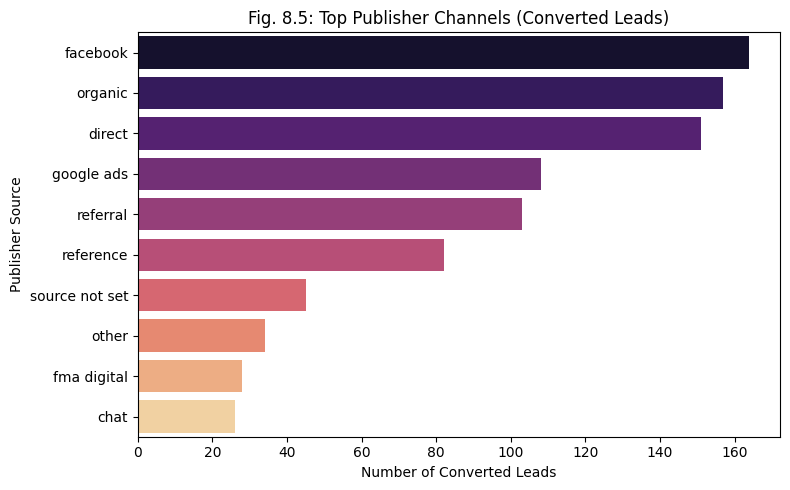

In [26]:
top_publishers = df_combined[df_combined['Converted'] == 1]['Publisher_Name_Clean'].value_counts().head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_publishers.values, y=top_publishers.index, palette='magma')
plt.title('Fig. 8.5: Top Publisher Channels (Converted Leads)')
plt.xlabel('Number of Converted Leads')
plt.ylabel('Publisher Source')
plt.tight_layout()
plt.show()

/tmp/ipython-input-1058767387.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=publisher_counts.values, y=publisher_counts.index, palette='magma')


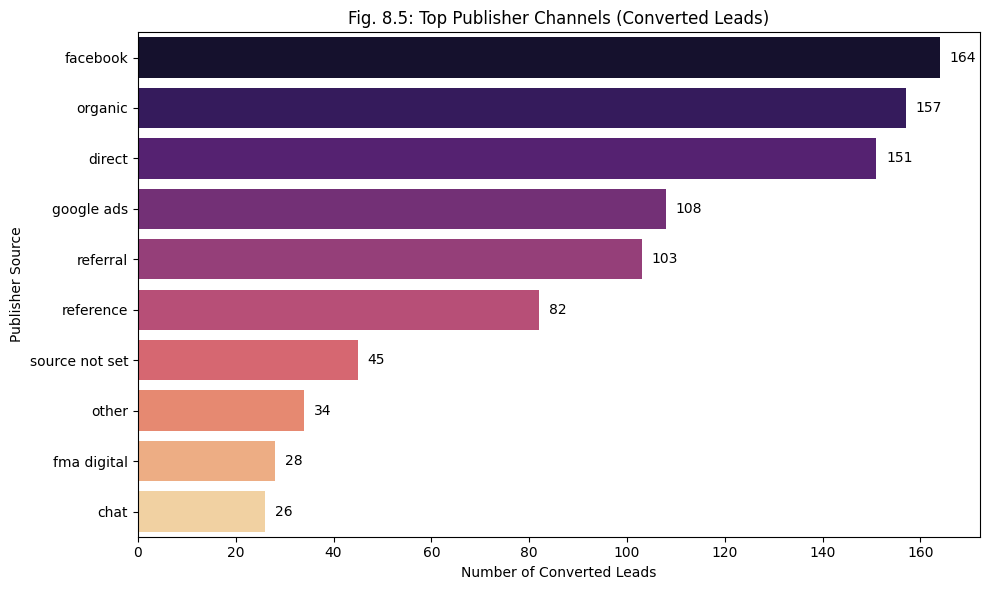

In [27]:
publisher_counts = df_combined[df_combined['Converted'] == 1]['Publisher_Name_Clean'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=publisher_counts.values, y=publisher_counts.index, palette='magma')

for index, value in enumerate(publisher_counts.values):
    plt.text(value + 2, index, str(value), va='center')

plt.title('Fig. 8.5: Top Publisher Channels (Converted Leads)')
plt.xlabel('Number of Converted Leads')
plt.ylabel('Publisher Source')
plt.tight_layout()
plt.show()


#Chi-Square Test Code

In [28]:
from scipy.stats import chi2_contingency

# Define a function for Chi-Square Test with formatted output
def chi_square_test(df, column, target='Converted'):
    contingency = pd.crosstab(df[column], df[target])
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"Chi-Square Test: {column} vs {target}")
    print("Chi2 Statistic:", round(chi2, 3))
    print("p-value:", round(p, 5))
    if p < 0.05:
        print("→ Statistically significant relationship (p < 0.05)\n")
    else:
        print("→ Not statistically significant (p >= 0.05)\n")
    return contingency


In [29]:
# Work Experience Band vs Conversion
contingency_exp = chi_square_test(df_combined, 'Work_Experience_Years', 'Converted')

# Industry Size Clean vs Conversion
contingency_industry = chi_square_test(df_combined, 'Industry_Size_Clean', 'Converted')

# Organization Clean – limit to top 10 for clearer interpretation
top_orgs = df_combined['Organization_Clean'].value_counts().nlargest(10).index
df_combined_top_org = df_combined[df_combined['Organization_Clean'].isin(top_orgs)]
contingency_org = chi_square_test(df_combined_top_org, 'Organization_Clean', 'Converted')

# Job Title Clean – limit to top 10 for meaningful test
top_jobs = df_combined['Job_Title_Clean'].value_counts().nlargest(10).index
df_combined_top_jobs = df_combined[df_combined['Job_Title_Clean'].isin(top_jobs)]
contingency_job = chi_square_test(df_combined_top_jobs, 'Job_Title_Clean', 'Converted')

Chi-Square Test: Work_Experience_Years vs Converted
Chi2 Statistic: 104.266
p-value: 0.0
→ Statistically significant relationship (p < 0.05)

Chi-Square Test: Industry_Size_Clean vs Converted
Chi2 Statistic: 702.089
p-value: 0.0
→ Statistically significant relationship (p < 0.05)

Chi-Square Test: Organization_Clean vs Converted
Chi2 Statistic: 247.328
p-value: 0.0
→ Statistically significant relationship (p < 0.05)

Chi-Square Test: Job_Title_Clean vs Converted
Chi2 Statistic: 2640.631
p-value: 0.0
→ Statistically significant relationship (p < 0.05)



In [30]:
contingency_exp.to_csv("ChiSquare_WorkExp_vs_Conversion.csv")
contingency_industry.to_csv("ChiSquare_Industry_vs_Conversion.csv")
contingency_org.to_csv("ChiSquare_Organization_vs_Conversion.csv")
contingency_job.to_csv("ChiSquare_JobTitle_vs_Conversion.csv")

/tmp/ipython-input-2416857759.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Chi2 Value', y='Feature', data=chi2_df, palette='viridis')


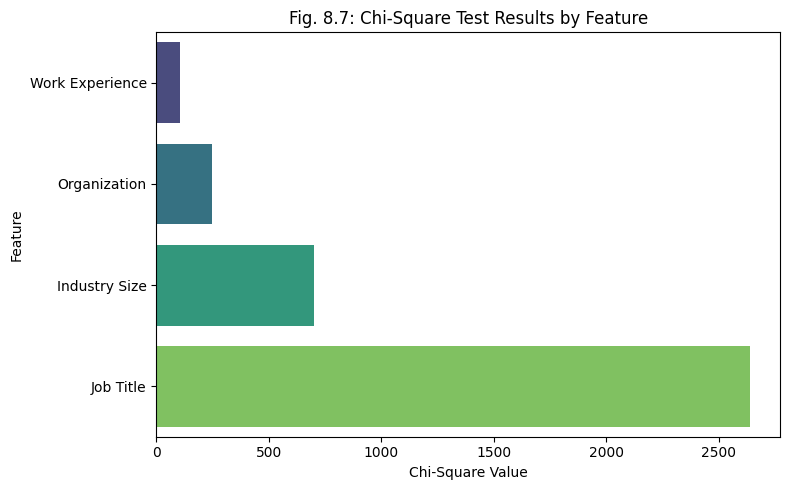

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Chi2 results dictionary
chi2_results = {
    'Work Experience': 104.27,
    'Industry Size': 702.08,
    'Organization': 247.33,
    'Job Title': 2640.63
}

# Convert to DataFrame for plotting
chi2_df = pd.DataFrame(list(chi2_results.items()), columns=['Feature', 'Chi2 Value'])
chi2_df = chi2_df.sort_values(by='Chi2 Value', ascending=True)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Chi2 Value', y='Feature', data=chi2_df, palette='viridis')
plt.title('Fig. 8.7: Chi-Square Test Results by Feature')
plt.xlabel('Chi-Square Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

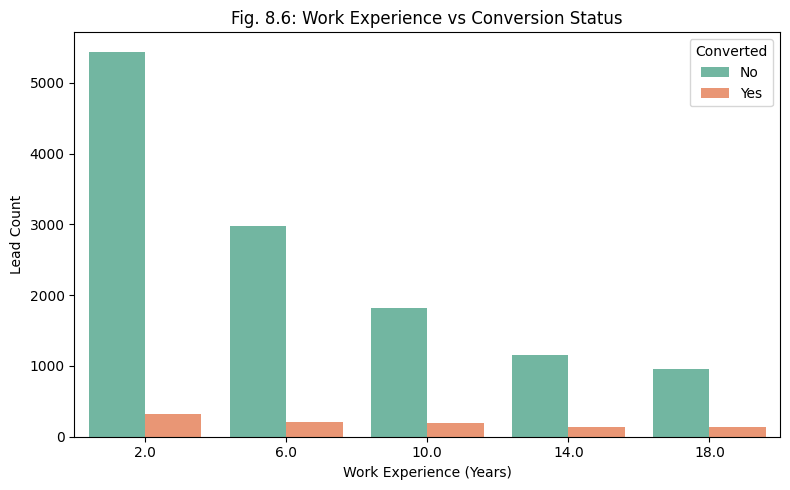

In [32]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_combined, x='Work_Experience_Years', hue='Converted', palette='Set2')
plt.title('Fig. 8.6: Work Experience vs Conversion Status')
plt.xlabel('Work Experience (Years)')
plt.ylabel('Lead Count')
plt.legend(title='Converted', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()


/tmp/ipython-input-3499577818.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_combined, x='Converted', y='Industry_Size_Clean', palette='coolwarm')


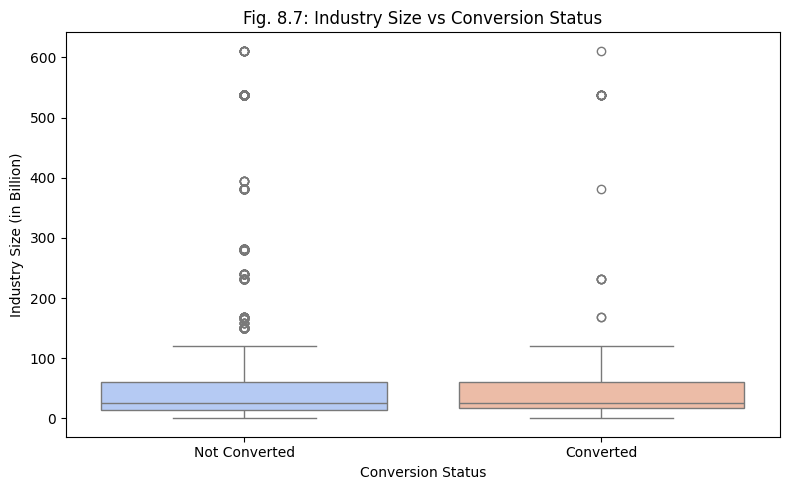

In [33]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_combined, x='Converted', y='Industry_Size_Clean', palette='coolwarm')
plt.title('Fig. 8.7: Industry Size vs Conversion Status')
plt.xlabel('Conversion Status')
plt.ylabel('Industry Size (in Billion)')
plt.xticks([0, 1], ['Not Converted', 'Converted'])
plt.tight_layout()
plt.show()


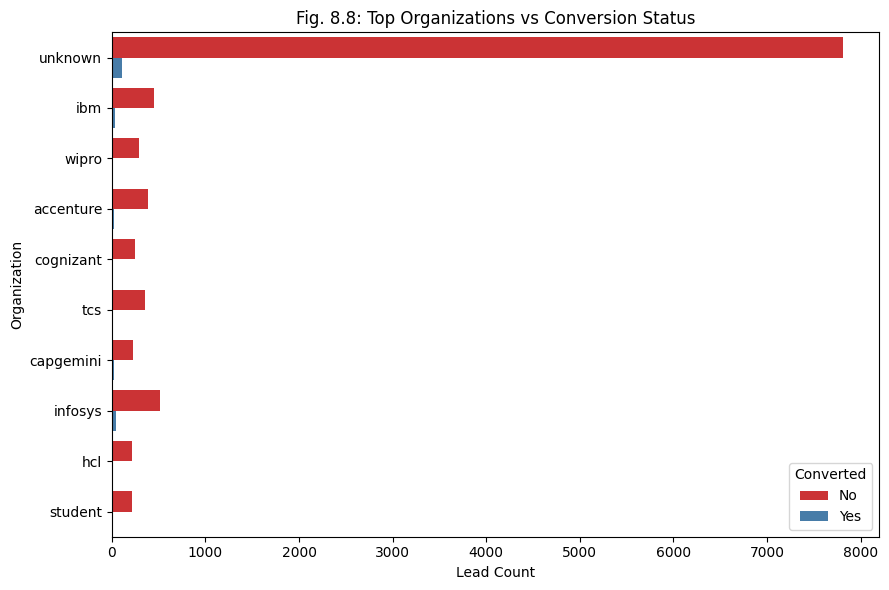

In [34]:
top_orgs = df_combined['Organization_Clean'].value_counts().head(10).index
filtered_data = df_combined[df_combined['Organization_Clean'].isin(top_orgs)]

plt.figure(figsize=(9, 6))
sns.countplot(data=filtered_data, y='Organization_Clean', hue='Converted', palette='Set1')
plt.title('Fig. 8.8: Top Organizations vs Conversion Status')
plt.xlabel('Lead Count')
plt.ylabel('Organization')
plt.legend(title='Converted', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()


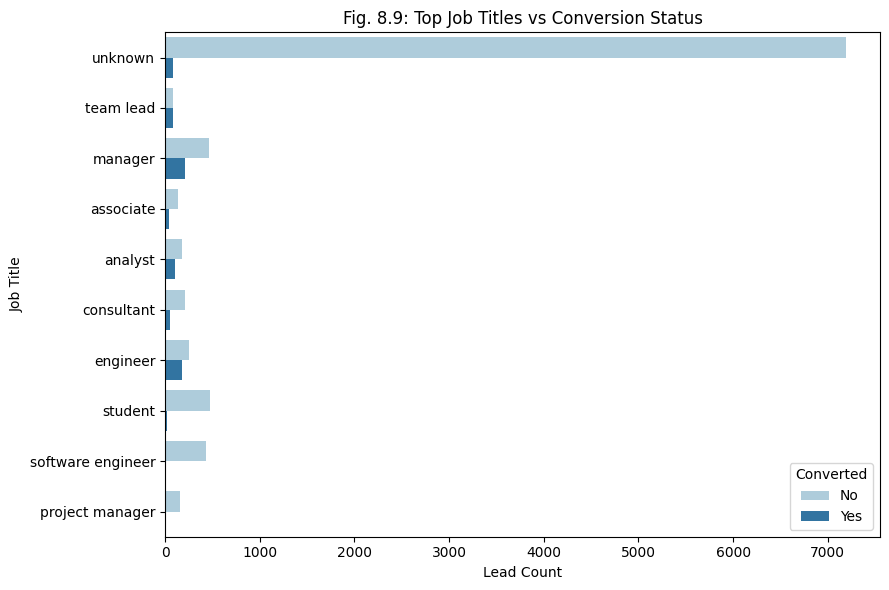

In [35]:
top_jobs = df_combined['Job_Title_Clean'].value_counts().head(10).index
filtered_jobs = df_combined[df_combined['Job_Title_Clean'].isin(top_jobs)]

plt.figure(figsize=(9, 6))
sns.countplot(data=filtered_jobs, y='Job_Title_Clean', hue='Converted', palette='Paired')
plt.title('Fig. 8.9: Top Job Titles vs Conversion Status')
plt.xlabel('Lead Count')
plt.ylabel('Job Title')
plt.legend(title='Converted', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()


#Baseline KNN Model (Imbalanced Data)

Train-Test Split + Baseline KNN + Evaluation

#fixing the dataset

Find Optimal K (Cross-validation)

Train Final KNN with Best K

Predict Lookalike Scores (on non-converted only)


Upsample the Converted Leads in Training Set

KNN Classification on Upsampled Data

ROC Curve

In [36]:
#Train Final KNN Model on Upsampled Data

In [37]:
'User Id' in not_converted_df.columns


True

#Grid Search on Upsampled Data

# Run GridSearchCV for KNN on Upsampled Data

#View Best Parameters

#Train Final Model with Best Params


#ROC Curve for Final Optimized KNN

#Generate Lookalike Scores Using Final Model

# Descriptive Statistics and Visual Insights

In [38]:
# Display the first few rows of the combined dataframe
display(df_combined.head())

# Display information about the combined dataframe
df_combined.info()

,Registered Name,Registered Email,Registered Mobile,Job Title,Work Experience,Organization,Industry,Industry Size (Billion),Type,Categoty,...,Publisher_Clean,Type_Clean,Job_Title_Clean_Encoded,Industry_Clean_Encoded,Organization_Clean_Encoded,Publisher_Clean_Encoded,Type_Clean_Encoded,Work_Exp_Scaled,Industry_Size_Scaled,Publisher_Name_Clean
0,TEST HARITHA,HARITHA.J@NOPAPERFORMS.COM,`+91-8792173812,XX,BELOW 4 YEARS,XX,NaN,NaN,NaN,NaN,...,referral,unknown,7799,89,10526,34,2,-0.893869,NaN,referral
1,VILMA FERNANDES,VILMABFERNANDES@GMAIL.COM,`+91-9538098880,NaN,4 TO 8 YEARS,NaN,NaN,NaN,NaN,NaN,...,source not set,unknown,7600,89,9926,38,2,-0.122477,NaN,source not set
2,ANIL KUMAR DILAIR,ANILDILAIR@GMAIL.COM,`+91-9888057111,FREELANCER,12 TO 16 YEARS,APPEN,NaN,NaN,NaN,NaN,...,facebook,unknown,2548,89,717,10,2,1.420306,NaN,facebook
3,SRINIVAS,KANISETTY.SRINIVAS@GMAIL.COM,`+91-9701831020,DEVOPS,8 TO 12 YEARS,OPENTEXT TECHNOLOGIES,NaN,NaN,NaN,NaN,...,organic,unknown,1971,89,6976,28,2,0.648915,NaN,organic
4,VINAYA JAMES,MEENAKSHY.6@GMAIL.COM,`+91-9742394855,Team Lead,8 TO 12 YEARS,L&T,Engineering & Construction,21.6,Indian,360000.0,...,organic,indian,7163,35,5695,28,0,0.648915,-0.358237,organic


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29340 entries, 0 to 29339
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Registered Name             29331 non-null  object 
 1   Registered Email            28478 non-null  object 
 2   Registered Mobile           28195 non-null  object 
 3   Job Title                   22065 non-null  object 
 4   Work Experience             13353 non-null  object 
 5   Organization                21428 non-null  object 
 6   Industry                    6519 non-null   object 
 7   Industry Size (Billion)     6450 non-null   float64
 8   Type                        6532 non-null   object 
 9   Categoty                    6516 non-null   float64
 10  Publisher Name              29340 non-null  object 
 11  Lead Score                  28711 non-null  float64
 12  Converted                   29340 non-null  int64  
 13  Work_Experience_Years       133

In [39]:
from sklearn.utils import resample
import pandas as pd

# Assuming df_model is your Analytical Base Table (ABT)
# Separate majority and minority classes from the ABT
df_majority = df_model[df_model['Converted'] == 0]
df_minority = df_model[df_model['Converted'] == 1]

print(f"🔸 Before Upsampling:\n - Converted=1: {len(df_minority)}\n - Not Converted=0: {len(df_majority)}")

# Upsample minority class
df_minority_upsampled = resample(
    df_minority,
    replace=True,                    # Sample with replacement
    n_samples=len(df_majority),      # Match majority class size
    random_state=42
)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Shuffle the dataset to mix the upsampled minority class with the majority class
df_upsampled = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n✅ After Upsampling:\n - Total Samples: {df_upsampled.shape[0]}")
print(df_upsampled['Converted'].value_counts())

🔸 Before Upsampling:
 - Converted=1: 452
 - Not Converted=0: 3630

✅ After Upsampling:
 - Total Samples: 7260
Converted
1    3630
0    3630
Name: count, dtype: int64


In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# STEP 1: Train-Test Split on Upsampled Data
X = df_upsampled.drop(columns=['Converted'])
y = df_upsampled['Converted']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)
print("Class distribution in test set:")
print(y_test.value_counts())

Train size: (5808, 7)
Test size: (1452, 7)
Class distribution in test set:
Converted
1    726
0    726
Name: count, dtype: int64


In [41]:
# STEP 2: Train Final KNN Model (k from earlier, or set default)
final_knn = KNeighborsClassifier(n_neighbors=29)
final_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=29)

In [42]:
# STEP 3: Predictions and Evaluation
y_pred = final_knn.predict(X_test)

print(" Classification Report (After Upsampling):")
print(classification_report(y_test, y_pred))

 Classification Report (After Upsampling):
              precision    recall  f1-score   support

           0       0.81      0.68      0.74       726
           1       0.72      0.84      0.78       726

    accuracy                           0.76      1452
   macro avg       0.77      0.76      0.76      1452
weighted avg       0.77      0.76      0.76      1452



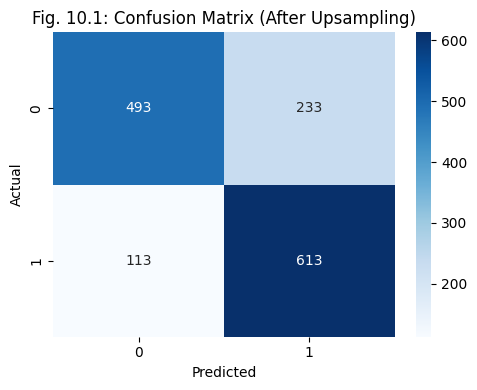

In [43]:
# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Fig. 10.1: Confusion Matrix (After Upsampling)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

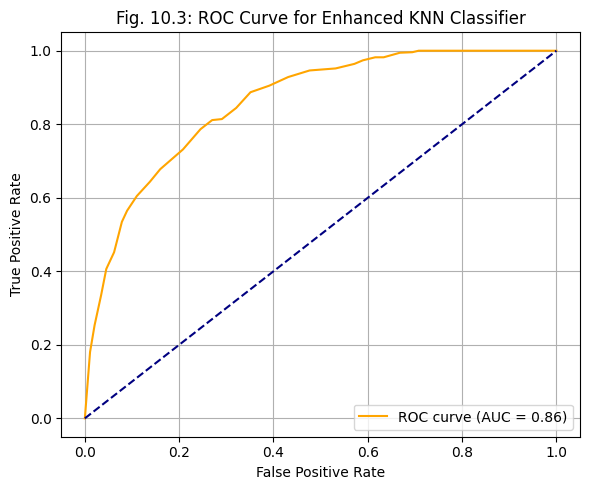

In [44]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities on test set
y_probs = final_knn.predict_proba(X_test)[:, 1]  # Probability for class 1
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Fig. 10.3: ROC Curve for Enhanced KNN Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

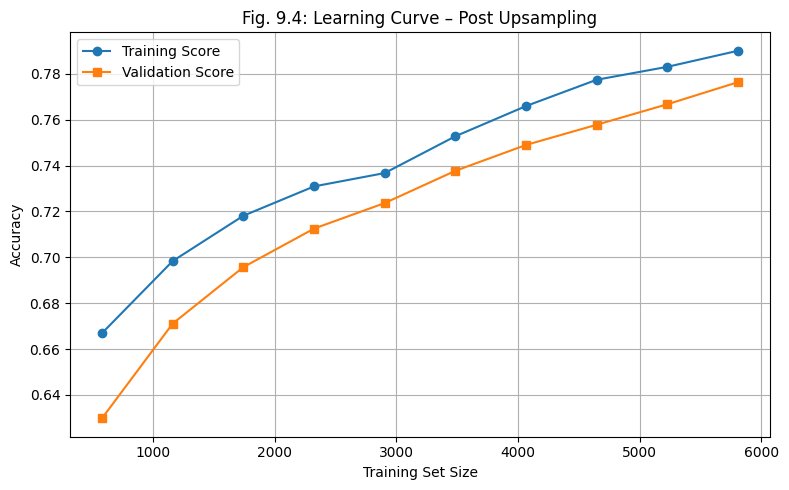

In [45]:
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Define model (using the same optimal k from earlier)
knn = KNeighborsClassifier(n_neighbors=29)

# Get learning curve values
# Use the full upsampled data (X, y) for the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    knn, X, y, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
)

# Compute mean and std
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Training Score", marker='o')
plt.plot(train_sizes, test_mean, label="Validation Score", marker='s')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Fig. 9.4: Learning Curve – Post Upsampling")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [46]:
# Step 1: Select the non-converted leads from the ABT (df_model)
X_not_converted_only = df_model[df_model['Converted'] == 0].drop(columns=['Converted'])

# Step 2: Predict lookalike scores using the final_knn model (trained after upsampling)
# Ensure final_knn model is defined and trained from previous steps (cell e8413234)
lookalike_scores = final_knn.predict_proba(X_not_converted_only)[:, 1]

# Step 3: Create a DataFrame with the original non-converted leads and their scores
df_scored_non_converted = df_model[df_model['Converted'] == 0].copy()
df_scored_non_converted['Lookalike_Score'] = lookalike_scores

# Step 4: Define the probability band function with user-specified thresholds
def assign_band(score):
    if score >= 0.80:
        return "Very High"
    elif score >= 0.60:
        return "High"
    elif score >= 0.40:
        return "Medium"
    else:
        return "Low"

# Step 5: Apply the function to create the 'Probability_Band' column
df_scored_non_converted['Probability_Band'] = df_scored_non_converted['Lookalike_Score'].apply(assign_band)

# Step 6: Prepare for merging with original data to get names, emails, etc.
# Ensure index is used as a key for merging
df_scored_non_converted['Original_Index'] = df_scored_non_converted.index
not_converted_df['Original_Index'] = not_converted_df.index # Make sure Original_Index exists in original df

# Step 7: Merge with original non_converted_df to get non-encoded columns
df_scored_full = df_scored_non_converted.merge(
    not_converted_df[[
        'Original_Index', 'Registered Name', 'Registered Email', 'Job Title',
        'Work Experience', 'Industry', 'Organization', 'Publisher Name' # Include Publisher Name
    ]],
    on='Original_Index',
    how='left'
)

# Drop the temporary index column
df_scored_full.drop(columns=['Original_Index'], inplace=True)

# Step 8: Reorder columns for better readability (optional but recommended)
final_export_columns = [
    'Registered Name', 'Registered Email', 'Job Title', 'Work Experience',
    'Organization', 'Industry', 'Publisher Name', 'Lookalike_Score',
    'Probability_Band',
    # Include the scaled and encoded features used in the model as well if needed, e.g.:
    # 'Work_Exp_Scaled', 'Industry_Size_Scaled', 'Job_Title_Clean_Encoded',
    # 'Industry_Clean_Encoded', 'Organization_Clean_Encoded', 'Publisher_Clean_Encoded',
    # 'Type_Clean_Encoded'
]
# Ensure all columns exist before selecting
final_export_columns = [col for col in final_export_columns if col in df_scored_full.columns]
df_scored_full = df_scored_full[final_export_columns]


# Step 9: Define output filenames
all_leads_filename = "All_Lookalike_Leads_Scored_Upsampled_Model.xlsx"
priority_leads_filename = "Priority_Leads_Upsampled_Model.xlsx"

# Step 10: Export the complete scored non-converted leads DataFrame to Excel
df_scored_full.to_excel(all_leads_filename, index=False)

# Step 11: Create a DataFrame for only "Very High" and "High" priority leads
df_priority_final = df_scored_full[df_scored_full['Probability_Band'].isin(['Very High', 'High'])]

# Step 12: Export the priority leads DataFrame to Excel
df_priority_final.to_excel(priority_leads_filename, index=False)

print(f"✅ All scored lookalike leads (Upsampled Model) exported to: {all_leads_filename}")
print(f"✅ Priority (Very High & High) lookalike leads (Upsampled Model) exported to: {priority_leads_filename}")

✅ All scored lookalike leads (Upsampled Model) exported to: All_Lookalike_Leads_Scored_Upsampled_Model.xlsx
✅ Priority (Very High & High) lookalike leads (Upsampled Model) exported to: Priority_Leads_Upsampled_Model.xlsx


In [47]:
# Display the first few rows of the scored DataFrame
print("✅ First 5 rows of the scored leads DataFrame:")
display(df_scored_full.head())

# Display information about the scored DataFrame
print("\n✅ Info about the scored leads DataFrame:")
df_scored_full.info()

✅ First 5 rows of the scored leads DataFrame:


,Registered Name,Registered Email,Job Title,Work Experience,Organization,Industry,Publisher Name,Lookalike_Score,Probability_Band
0,SANDEEP SHARMA,NaN,APPLICATION DEVELOPER,8 TO 12 YEARS,IBM,"IT Services, Cloud, AI",TELEPHONY OUTBOUND,0.724138,High
1,NAME,NaN,NaN,BELOW 4 YEARS,NaN,NaN,ONLINE SESSION,0.000000,Low
2,AKASASH,NaN,NaN,BELOW 4 YEARS,NaN,NaN,ONLINE SESSION,0.000000,Low
3,PUSHPASENTHIL,PUSHPASCHOLAR@EGSPEC.ORG,E.G.S.PILLAY ENGINEERING COLLEGE,BELOW 4 YEARS,ASSISTANT PROFESSOR,NaN,ONLINE SESSION,0.931034,Very High
4,CHAKRAVARTHI VADLAMANI,CHAKRIVADLAMANI41@GMAIL.COM,STUDENT,BELOW 4 YEARS,COMPUTER SCIENCE,NaN,ONLINE SESSION,0.206897,Low



✅ Info about the scored leads DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3630 entries, 0 to 3629
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Registered Name   3495 non-null   object 
 1   Registered Email  3413 non-null   object 
 2   Job Title         2636 non-null   object 
 3   Work Experience   1606 non-null   object 
 4   Organization      2553 non-null   object 
 5   Industry          739 non-null    object 
 6   Publisher Name    3495 non-null   object 
 7   Lookalike_Score   3630 non-null   float64
 8   Probability_Band  3630 non-null   object 
dtypes: float64(1), object(8)
memory usage: 255.4+ KB


/tmp/ipython-input-2116605720.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=band_counts.index, y=band_counts.values, palette='viridis')


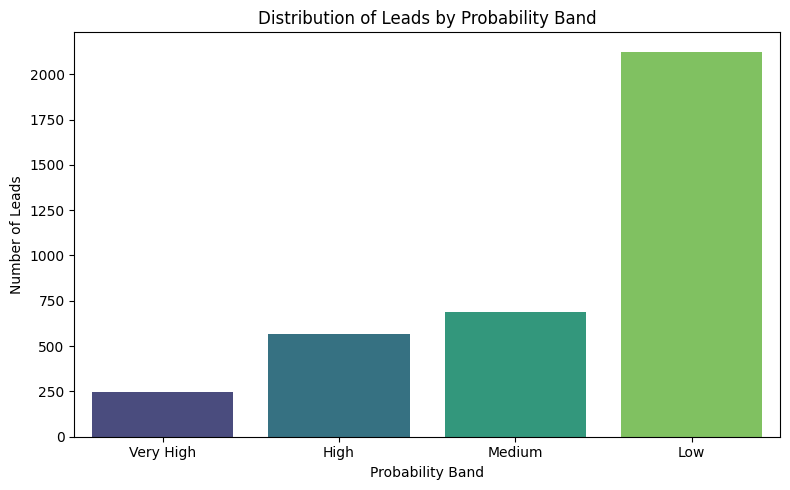

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the number of leads in each probability band
band_counts = df_scored_full['Probability_Band'].value_counts().reindex(['Very High', 'High', 'Medium', 'Low'])

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(x=band_counts.index, y=band_counts.values, palette='viridis')
plt.title("Distribution of Leads by Probability Band")
plt.xlabel("Probability Band")
plt.ylabel("Number of Leads")
plt.tight_layout()
plt.show()

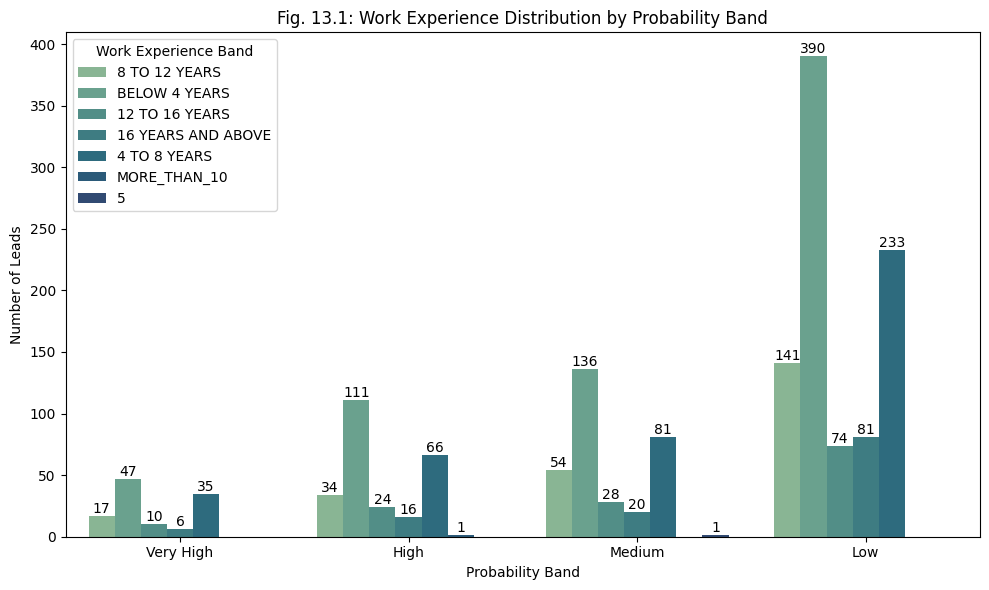

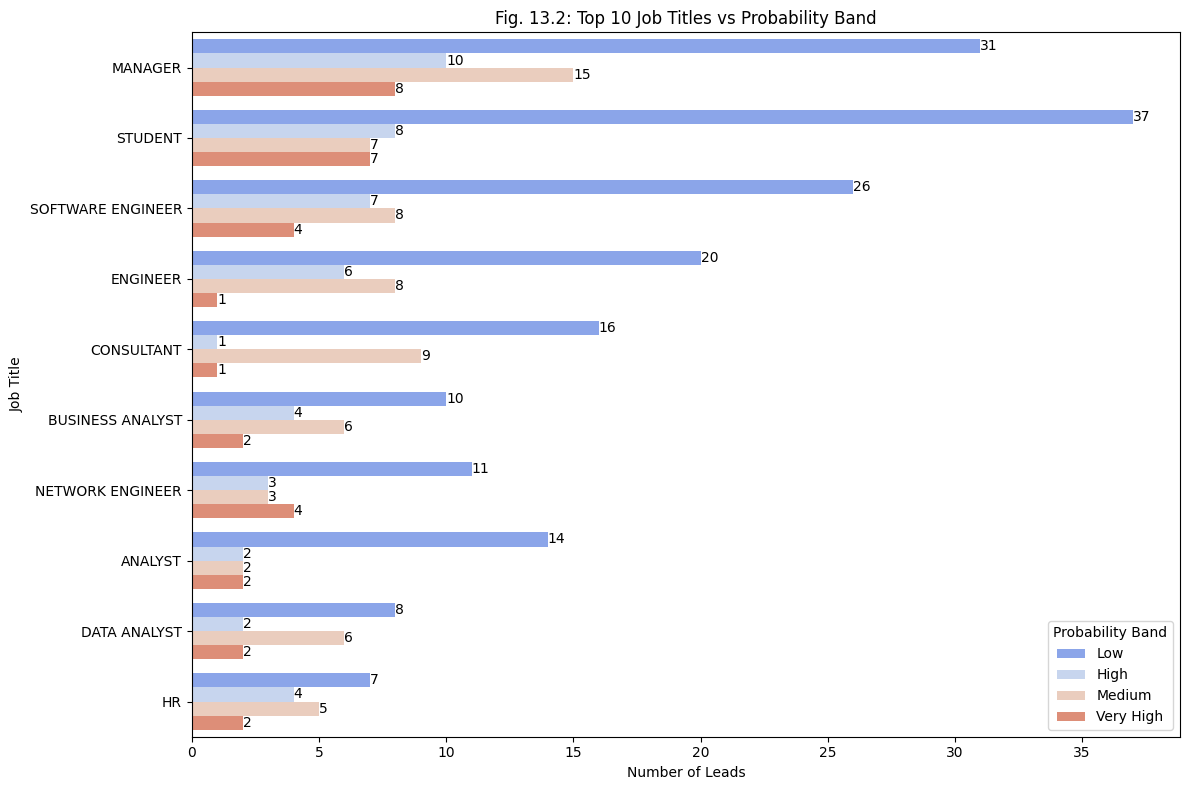

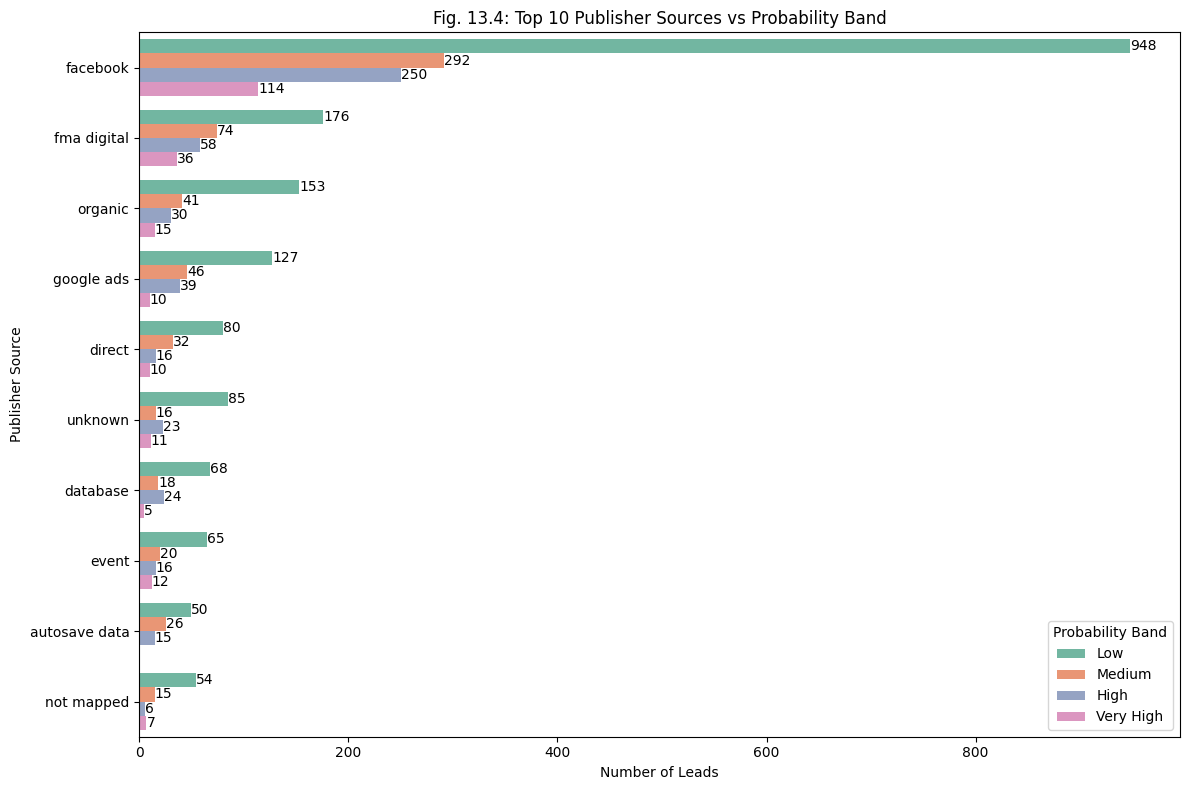

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Ensure the Work_Experience_Years column is available and numeric
# (Assuming it was created and processed correctly in earlier steps)
# If not, you might need to re-run the cell that creates 'Work_Experience_Years'

# Re-create the Work_Experience_Years column in df_scored_full based on 'Work Experience'
# This function should match the one used earlier in cell E8pAz6IYLZb_ or 65wXpkIJ5hJZ
def convert_work_experience_years(exp):
    if pd.isna(exp) or exp == 'NA':
        return np.nan
    exp = str(exp).upper()
    if 'BELOW 4' in exp:
        return 2
    elif '4 TO 8' in exp:
        return 6
    elif '8 TO 12' in exp:
        return 10
    elif '12 TO 16' in exp:
        return 14
    elif '16 YEARS' in exp:
        return 18
    # Handle cases with just a number or specific text like 'FRESHER'
    match_years = re.search(r'(\d+)\s*YEARS?', exp)
    if match_years:
        return float(match_years.group(1))
    elif 'FRESHER' in exp:
        return 0 # Assign 0 for freshers or entry-level

    return np.nan # Return NaN for any other unhandled cases

# Apply the function to create Work_Experience_Years in df_scored_full
df_scored_full['Work_Experience_Years'] = df_scored_full['Work Experience'].apply(convert_work_experience_years)

# Ensure Publisher_Clean_Name is available in df_scored_full
# This involves mapping from Publisher_Clean_Encoded using the original encoder
if 'Publisher_Clean_Encoded' in df_scored_full.columns and 'publisher_encoder' in globals():
    df_scored_full['Publisher_Clean_Name'] = publisher_encoder.inverse_transform(df_scored_full['Publisher_Clean_Encoded'])
elif 'Publisher Name' in df_scored_full.columns:
     # Fallback: Use the original 'Publisher Name' if encoding/mapping is problematic
     df_scored_full['Publisher_Clean_Name'] = df_scored_full['Publisher Name'].fillna('unknown').str.lower().str.strip().str.replace(r'[^a-zA-Z0-9 ]', '', regex=True)
else:
    print("Warning: Could not create 'Publisher_Clean_Name'. Publisher plot may fail.")


# --- Work Experience vs. Probability Band (using countplot with labels) ---
# Using original 'Work Experience' column for cleaner countplot by band
if 'Work Experience' in df_scored_full.columns:
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=df_scored_full, x='Probability_Band', hue='Work Experience',
                       order=['Very High', 'High', 'Medium', 'Low'], palette='crest')
    plt.title('Fig. 13.1: Work Experience Distribution by Probability Band')
    plt.xlabel('Probability Band')
    plt.ylabel('Number of Leads')
    plt.legend(title='Work Experience Band') # Changed legend title to reflect bands

    # Add data labels - this might be very crowded depending on the number of hue categories
    # Consider removing data labels if the plot is unreadable due to many bars.
    # For countplot, bar_label works on containers.
    try:
        for container in ax.containers:
            ax.bar_label(container, fmt='%d', label_type='edge')
    except Exception as e:
        print(f"Could not add data labels to Work Experience plot: {e}")
        print("Consider simplifying the plot or removing labels if too many categories.")

    plt.tight_layout()
    plt.show()
else:
    print(" 'Work Experience' column not found in df_scored_full. Cannot generate Work Experience plot.")


# --- Job Title vs. Probability Band (Top N, with labels) ---
# Select top N job titles for clarity
top_n_jobs = 10
# Ensure 'Job Title' column exists in df_scored_full. It should, based on the merge step in cell go9GtIVfFCEJ.
if 'Job Title' in df_scored_full.columns:
    top_titles = df_scored_full['Job Title'].value_counts().head(top_n_jobs).index
    filtered_jobs = df_scored_full[df_scored_full['Job Title'].isin(top_titles)]

    plt.figure(figsize=(12, 8))
    ax = sns.countplot(data=filtered_jobs, y='Job Title', hue='Probability_Band',
                       order=top_titles, palette='coolwarm')
    plt.title(f'Fig. 13.2: Top {top_n_jobs} Job Titles vs Probability Band')
    plt.xlabel('Number of Leads')
    plt.ylabel('Job Title')
    plt.legend(title='Probability Band')

    # Add data labels
    try:
        for container in ax.containers:
            ax.bar_label(container, fmt='%d', label_type='edge')
    except Exception as e:
        print(f"Could not add data labels to Job Title plot: {e}")


    plt.tight_layout()
    plt.show()
else:
    print(" 'Job Title' column not found in df_scored_full. Cannot generate Job Title plot.")


# --- Publisher Source vs. Probability Band (Top N, with labels) ---
# Select top N publishers for clarity
top_n_publishers = 10
# Ensure 'Publisher_Clean_Name' or 'Publisher Name' column exists in df_scored_full.
if 'Publisher_Clean_Name' in df_scored_full.columns:
    top_publishers = df_scored_full['Publisher_Clean_Name'].value_counts().head(top_n_publishers).index
    filtered_publishers = df_scored_full[df_scored_full['Publisher_Clean_Name'].isin(top_publishers)]

    plt.figure(figsize=(12, 8))
    ax = sns.countplot(data=filtered_publishers, y='Publisher_Clean_Name', hue='Probability_Band',
                       order=top_publishers, palette='Set2')
    plt.title(f'Fig. 13.4: Top {top_n_publishers} Publisher Sources vs Probability Band')
    plt.xlabel('Number of Leads')
    plt.ylabel('Publisher Source')
    plt.legend(title='Probability Band')

    # Add data labels
    try:
        for container in ax.containers:
            ax.bar_label(container, fmt='%d', label_type='edge')
    except Exception as e:
        print(f"Could not add data labels to Publisher plot: {e}")

    plt.tight_layout()
    plt.show()
else:
    print(" 'Publisher_Clean_Name' or 'Publisher Name' column not found in df_scored_full. Cannot generate Publisher plot.")

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, make_scorer

# Define model and parameter grid
knn = KNeighborsClassifier()

# Define the parameter grid to search over
param_grid = {
    'n_neighbors': list(range(3, 31, 2)), # Search odd values of k from 3 to 29
    'metric': ['euclidean', 'manhattan'] # Compare distance metrics
}

# Use F1-score as the scoring metric for Grid Search
# F1-score is a good choice for imbalanced datasets
scorer = make_scorer(f1_score)

# Set up Grid Search with 5-fold cross-validation
# verbose=1 shows progress, n_jobs=-1 uses all available cores
grid_search = GridSearchCV(knn, param_grid, scoring=scorer, cv=5, verbose=1, n_jobs=-1)

# Run the Grid Search on the upsampled training data
# Assuming X_train and y_train from the upsampled data split are available
grid_search.fit(X_train, y_train)

print("✅ Grid Search complete.")

Fitting 5 folds for each of 28 candidates, totalling 140 fits
✅ Grid Search complete.


In [51]:
# Get the best parameters and best score from the Grid Search
print("🔍 Best Parameters found by Grid Search:")
print(grid_search.best_params_)
print("\n⭐ Best Cross-Validation F1-Score:")
print(grid_search.best_score_)

# You can also access the best estimator directly
best_knn_model = grid_search.best_estimator_
print("\n✅ Best KNN Model:")
print(best_knn_model)

🔍 Best Parameters found by Grid Search:
{'metric': 'euclidean', 'n_neighbors': 3}

⭐ Best Cross-Validation F1-Score:
0.9200451707950478

✅ Best KNN Model:
KNeighborsClassifier(metric='euclidean', n_neighbors=3)


In [52]:
from sklearn.metrics import classification_report

# Train final KNN with best hyperparameters
final_knn_optimized = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'],
                                           metric=grid_search.best_params_['metric'])
final_knn_optimized.fit(X_train, y_train)

# Predict and evaluate
y_pred_optimized = final_knn_optimized.predict(X_test)

print(" Classification Report (After GridSearch):")
print(classification_report(y_test, y_pred_optimized))

 Classification Report (After GridSearch):
              precision    recall  f1-score   support

           0       1.00      0.85      0.92       726
           1       0.87      1.00      0.93       726

    accuracy                           0.92      1452
   macro avg       0.93      0.92      0.92      1452
weighted avg       0.93      0.92      0.92      1452



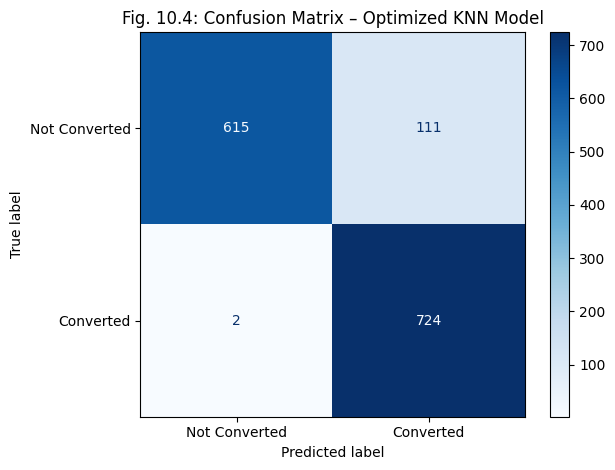

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict again (if not already done)
y_pred_optimized = final_knn_optimized.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_optimized)

# Display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Converted", "Converted"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Fig. 10.4: Confusion Matrix – Optimized KNN Model")
plt.grid(False)
plt.tight_layout()
plt.show()

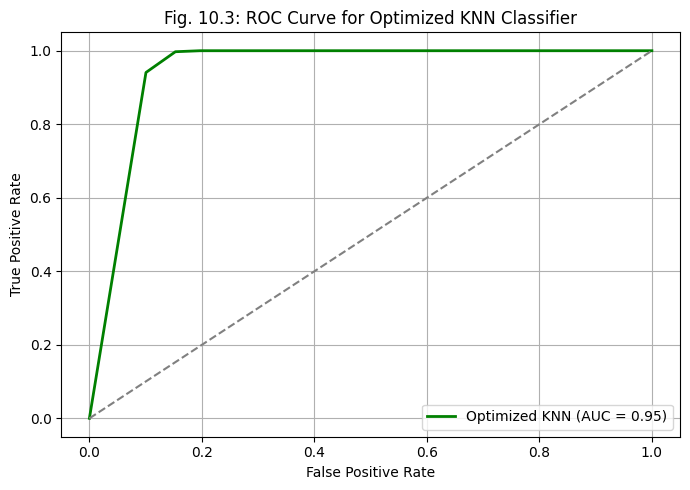

In [54]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities on test set
y_probs_optimized = final_knn_optimized.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs_optimized)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='green', lw=2, label='Optimized KNN (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("Fig. 10.3: ROC Curve for Optimized KNN Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

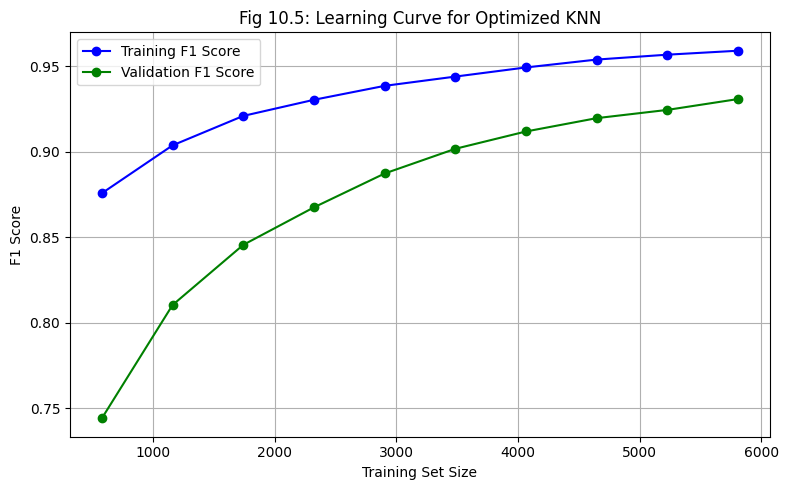

In [55]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    estimator=final_knn_optimized,
    X=X, # Use X (full upsampled feature matrix)
    y=y, # Use y (full upsampled target vector)
    cv=StratifiedKFold(n_splits=5),
    scoring='f1', # Using F1-score as it's better for imbalanced data
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

# Mean scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training F1 Score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Validation F1 Score')
plt.title("Fig 10.5: Learning Curve for Optimized KNN")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

Calculating Permutation Importance...

✅ Permutation Importance Results:
                      Feature  Importance
0        Industry_Size_Scaled    0.000000
1          Type_Clean_Encoded    0.000000
2      Industry_Clean_Encoded    0.007645
3             Work_Exp_Scaled    0.009298
4     Publisher_Clean_Encoded    0.026997
5  Organization_Clean_Encoded    0.178926
6     Job_Title_Clean_Encoded    0.397796


/tmp/ipython-input-3256125099.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


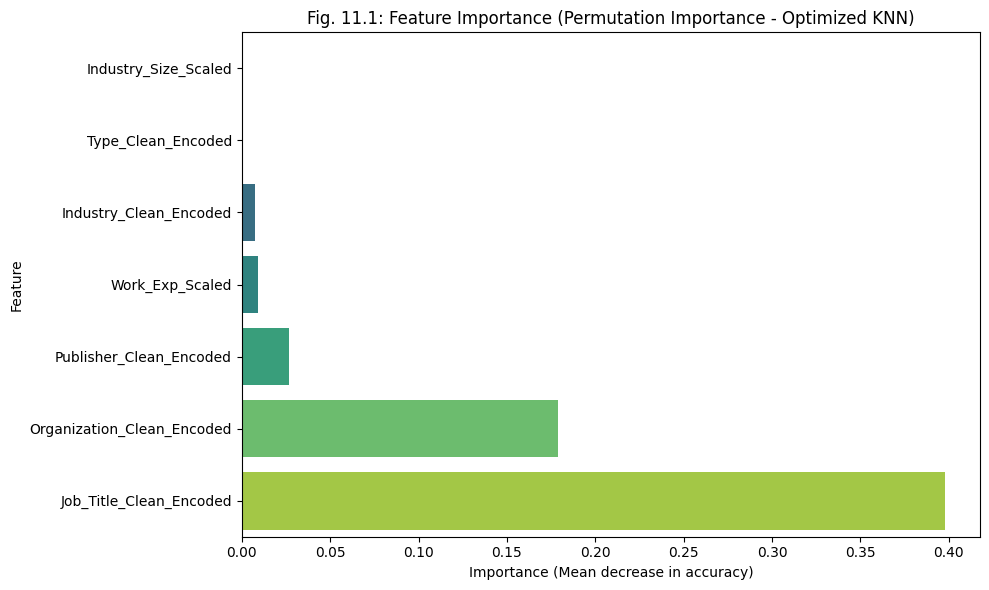

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Let's use Permutation Importance as a more robust method for KNN
from sklearn.inspection import permutation_importance

# Assuming X_test and y_test from the upsampled data split (cell a5f6ddd8) are available
# Assuming final_knn_optimized model is trained (cell b11c6943)

if 'final_knn_optimized' in globals() and 'X_test' in globals() and 'y_test' in globals():
    print("Calculating Permutation Importance...")

    # Perform permutation importance
    # n_repeats: number of times to permute a feature
    # random_state: for reproducibility
    # n_jobs: use all available cores (-1)
    perm_importance = permutation_importance(
        final_knn_optimized,
        X_test,
        y_test,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )

    # Get mean importance and sort
    sorted_idx = perm_importance.importances_mean.argsort()
    feature_names = X_test.columns[sorted_idx]
    importance_values = perm_importance.importances_mean[sorted_idx]

    # Create a DataFrame for easier plotting
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_values
    })

    print("\n✅ Permutation Importance Results:")
    print(importance_df)

    # Plotting Feature Importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title('Fig. 11.1: Feature Importance (Permutation Importance - Optimized KNN)')
    plt.xlabel('Importance (Mean decrease in accuracy)')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

else:
    print("❌ Required variables (final_knn_optimized, X_test, y_test) not found.")
    print("Please ensure the model training and data splitting steps were executed successfully.")

In [57]:
# These are the non-converted leads passed to the model
# Using df_model subset where Converted == 0
df_model_ready_not_converted = df_model[df_model['Converted'] == 0].copy()

# Predict scores for these only using the optimized model
# Ensure final_knn_optimized model is defined and trained from previous steps (cell b11c6943)
lookalike_scores_updated = final_knn_optimized.predict_proba(df_model_ready_not_converted.drop(columns=['Converted']))[:, 1]

# Attach lookalike scores to this subset
df_model_ready_not_converted['Lookalike_Score'] = lookalike_scores_updated

# Define the probability band function with user-specified thresholds
def assign_band(score):
    if score >= 0.80:
        return "Very High"
    elif score >= 0.60:
        return "High"
    elif score >= 0.40:
        return "Medium"
    else:
        return "Low"

# Apply the function to create the 'Probability_Band' column
df_model_ready_not_converted['Probability_Band'] = df_model_ready_not_converted['Lookalike_Score'].apply(assign_band)

# Prepare for merging with original data to get names, emails, etc.
# Ensure index is used as a key for merging
df_model_ready_not_converted['Original_Index'] = df_model_ready_not_converted.index
# Ensure not_converted_df has 'Original_Index' column set from its index, as done in cell go9GtIVfFCEJ
not_converted_df['Original_Index'] = not_converted_df.index


# Merge with original non_converted_df to get non-encoded columns
# Include all columns from df_model_ready_not_converted and selected original columns
df_scored_full = df_model_ready_not_converted.merge(
    not_converted_df[[
        'Original_Index', 'Registered Name', 'Registered Email', 'Job Title',
        'Work Experience', 'Industry', 'Organization', 'Publisher Name', 'Registered Mobile' # Added Mobile as it might be useful
    ]],
    on='Original_Index',
    how='left'
)

# Drop the temporary index column and the 'Converted' column (as they are all not converted)
df_scored_full.drop(columns=['Original_Index', 'Converted'], inplace=True)

# Reorder columns for better readability - include all columns plus score and band
# Get all original columns from df_model_ready_not_converted (except Converted, Lookalike_Score, Probability_Band, Original_Index)
model_features = [col for col in df_model_ready_not_converted.columns if col not in ['Converted', 'Lookalike_Score', 'Probability_Band', 'Original_Index']]
# Get original data columns used in merge (except Original_Index)
original_data_features = ['Registered Name', 'Registered Email', 'Job Title', 'Work Experience',
                         'Organization', 'Industry', 'Publisher Name', 'Registered Mobile']

# Combine and ensure uniqueness, prioritizing original data features
all_cols = list(set(original_data_features + model_features))

# Define preferred order - put original identifying info and score/band first
preferred_order = [
    'Registered Name', 'Registered Email', 'Registered Mobile', 'Job Title', 'Work Experience',
    'Organization', 'Industry', 'Publisher Name', 'Lookalike_Score', 'Probability_Band'
]

# Add other columns not in preferred order
other_cols = [col for col in all_cols if col not in preferred_order]
final_export_columns = preferred_order + other_cols

# Ensure all columns exist before selecting
final_export_columns = [col for col in final_export_columns if col in df_scored_full.columns]
df_scored_full = df_scored_full[final_export_columns]


# Step: Sort and get top 10 lookalikes for display
df_top_lookalikes_sorted = df_scored_full.sort_values(by='Lookalike_Score', ascending=False)

print("🎯 Top 10 Lookalike Leads (Optimized Model):")
# Display only key columns for top 10 display
display(df_top_lookalikes_sorted[[
    'Registered Name', 'Registered Email', 'Job Title', 'Work Experience',
    'Organization', 'Industry', 'Publisher Name', 'Lookalike_Score', 'Probability_Band'
]].head(10))

# Step: Export the complete scored dataset to Excel
all_leads_filename = "All_Lookalike_Leads_Scored_Optimized_Model.xlsx"
df_scored_full.to_excel(all_leads_filename, index=False)

print(f"\n✅ Complete scored lookalike leads (Optimized Model) exported to: {all_leads_filename}")

# Optional: Export the priority leads as well (Very High and High)
priority_leads_filename = "Priority_Leads_Optimized_Model.xlsx"
df_priority_final = df_scored_full[df_scored_full['Probability_Band'].isin(['Very High', 'High'])]
df_priority_final.to_excel(priority_leads_filename, index=False)
print(f"✅ Priority (Very High & High) lookalike leads (Optimized Model) exported to: {priority_leads_filename}")

🎯 Top 10 Lookalike Leads (Optimized Model):


,Registered Name,Registered Email,Job Title,Work Experience,Organization,Industry,Publisher Name,Lookalike_Score,Probability_Band
514,VENKATESH POLISETTI,VENKIP41@GMAIL.COM,LEAD DEVOPS ENGINEER,8 TO 12 YEARS,INFO CREDIT SOLUTIONS,NaN,LINKEDIN,1.0,Very High
3179,DR NEKKANTI KUMARASWAMY,DEAN@VVIT.NET,PROFESSOR,BELOW 4 YEARS,VVIT,NaN,EMAIL,1.0,Very High
2863,KR SABAREESH IYER MOUDGALYA,SHAMBOSABAREESH@GMAIL.COM,NaN,16 YEARS AND ABOVE,AVIAN AEROSPACE,Aerospace,FMA DIGITAL,1.0,Very High
497,MANJULA,MANJU5656@GMAIL.COM,SELF EMPLOYED,12 TO 16 YEARS,ILYAS POLISH,NaN,FACEBOOK,1.0,Very High
2503,SHETTY,BASAVARAJSHETTY.M@REVA.EDU.IN,NaN,NaN,NaN,NaN,ONLINE SESSION,1.0,Very High
885,NOORBASHU ANWAR,ANWAR.DIL143@GMAIL.COM,NIL,12 TO 16 YEARS,NIL,NaN,FACEBOOK,1.0,Very High
888,SHYAM,S_MAJUMDER@REDIFFMAIL.COM,DELIVERY MANAGER,16 YEARS AND ABOVE,KYNDRYL,IT Infrastructure Services,FACEBOOK,1.0,Very High
2255,LAKSHMIKANTH KANTHA,LSKANTHA019@GMAIL.COM,SYSTEM ENGINEER,BELOW 4 YEARS,PRECISION,NaN,FACEBOOK,1.0,Very High
3567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Very High
2252,VINAYAK BETAGERI,VINAYAKBETAGERI11@GMAIL.COM,BE 2ND YEAR,NaN,STUDENT,NaN,FACEBOOK,1.0,Very High



✅ Complete scored lookalike leads (Optimized Model) exported to: All_Lookalike_Leads_Scored_Optimized_Model.xlsx
✅ Priority (Very High & High) lookalike leads (Optimized Model) exported to: Priority_Leads_Optimized_Model.xlsx


In [58]:
import pickle
import joblib

# Define the filename for the pickle file
model_filename = 'final_knn_optimized_model.pkl'

# Save the final_knn_optimized model to a pickle file
# Using joblib is often more efficient for scikit-learn models
joblib.dump(final_knn_optimized, model_filename)

print(f"✅ Final optimized KNN model saved to '{model_filename}'")

# To download the file in Google Colab, you can use the files module
from google.colab import files

# Download the file
# files.download(model_filename) # Uncomment this line if you want to automatically trigger download

print(f"The model file '{model_filename}' is now available for download.")
print("You can download it manually from the file browser in the left sidebar (folder icon).")

✅ Final optimized KNN model saved to 'final_knn_optimized_model.pkl'
The model file 'final_knn_optimized_model.pkl' is now available for download.
You can download it manually from the file browser in the left sidebar (folder icon).
